<a href="https://www.kaggle.com/code/kapilstp84/everything-you-need-to-know-about-arima?scriptVersionId=139385724" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# SARIMAX case study

## This kernel solves a foreasting business problem using SARIMAX. It's an end to end case study including data preparation, data cleansing to model building & automatic hyper parameter tuning.
## Below concepts/plots are used:

* Plotting ACF (auto-correlation function) & PACF (Partial auto-correlation function) charts
* Test stationarity of data by trying various data transformations / Dickey Fuller Test
* Outlier Detection & Treatment
* Parameter fine tuning (p*d*q)X(P*D*Q)S
* Auto-selecting best model / Min AIC
* Plotting forecasts


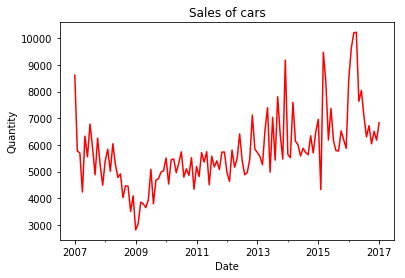

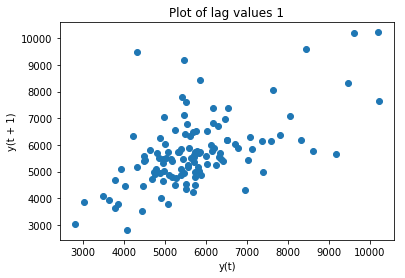

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.


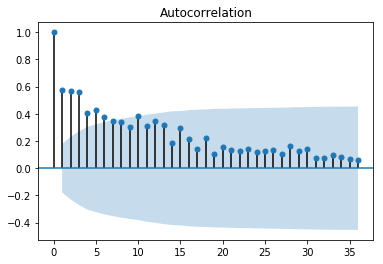

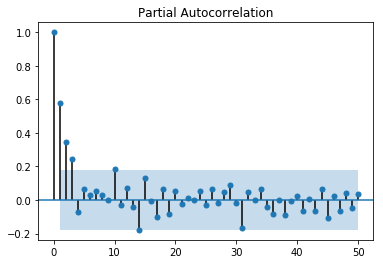

In [1]:
# load and plot dataset
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from importlib import reload
from numpy import array
import numpy

import sys
from imp import reload
if sys.version[0] == '2':
    reload(sys)
    sys.setdefaultencoding("utf-8")

#Importing data
df = read_csv('../input/norway_new_car_sales_by_model.csv',encoding='cp1252')

#Printing head
df.head()
df.tail()

# Summarizing the dataset
#How many rows the dataset have
df['Quantity'].count()

from pandas import Series, DataFrame
import pandas as pd
import matplotlib.pyplot as plt 

df['Date'] = pd.to_datetime(df.assign(Day=1).loc[:, ['Year','Month','Day']])
#retain only date & quantity
df = df[['Date','Quantity']]
df = df.groupby(['Date']).sum()
df.head()

# Plotting data
df['Quantity'].plot(color='red')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Sales of cars')
plt.show()

# The plot created from running the below shows a relatively strong positive correlation between observations and their lag1 values
from pandas.plotting import lag_plot
lag_plot(df)
plt.title('Plot of lag values 1')
pyplot.show()


# Autocorrelation plot for the time series
from pandas.plotting import autocorrelation_plot
from pandas.core import datetools
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df, lags=36)
pyplot.show

# Partial Autocorrelation plot for the time series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df, lags=50)
pyplot.show()

### Stationarity / Order of Differencing / Transformation / Dickey - Fuller Test

* The first step is to test stationarity of data. In this section we try various data transformations & test for stationarity of the transformed data. 
* The best order of differencing or transformation is decided as per adf & what makes business sense. 
* It is likely that a particular transformation/differencing provides significant adf results but it should be used only if it makes business sense.

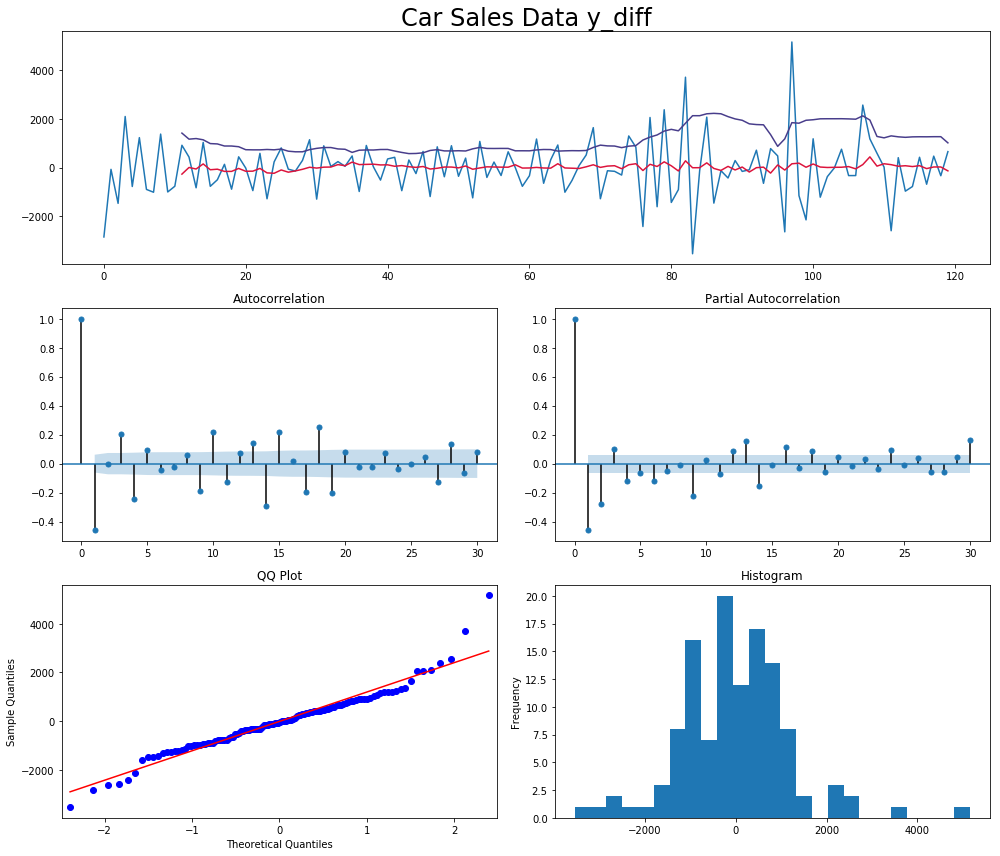

Results of Dickey-Fuller test:
test statistic           -3.166795
p-value                   0.021989
# of lags                12.000000
# of observations       107.000000
Critical Value (1%)      -3.492996
Critical Value (5%)      -2.888955
Critical Value (10%)     -2.581393
dtype: float64


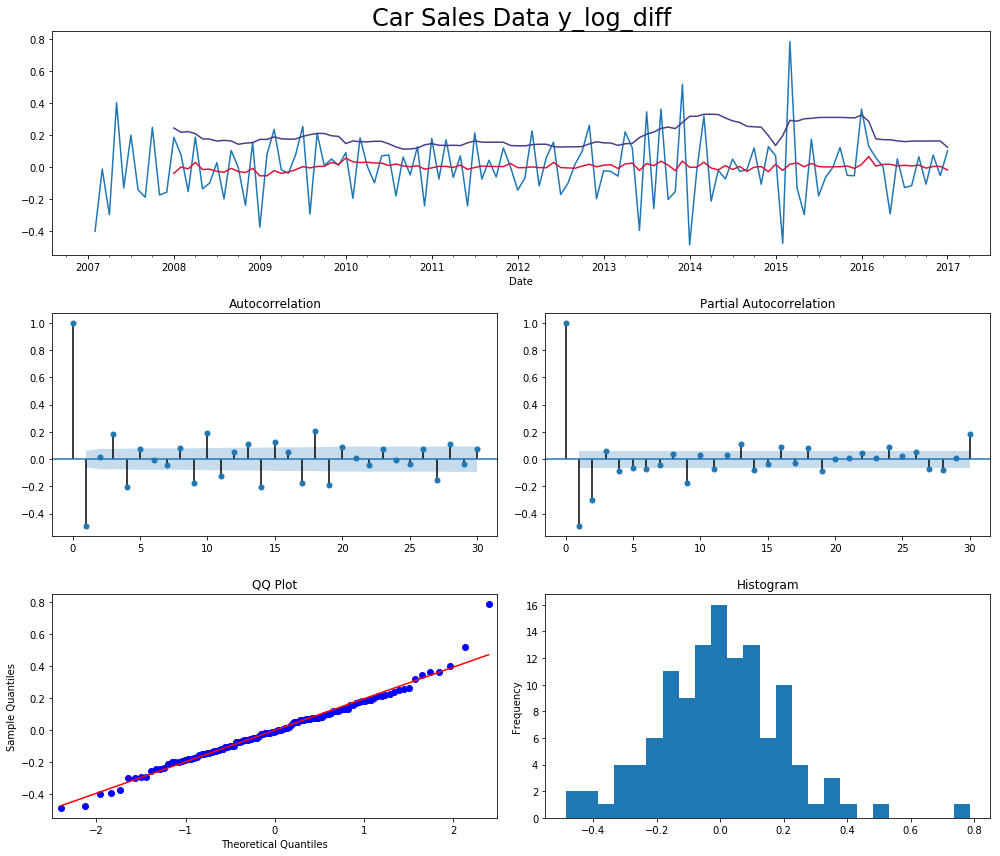

Results of Dickey-Fuller test:
test statistic         -1.325581e+01
p-value                 8.592769e-25
# of lags               1.000000e+00
# of observations       1.180000e+02
Critical Value (1%)    -3.487022e+00
Critical Value (5%)    -2.886363e+00
Critical Value (10%)   -2.580009e+00
dtype: float64


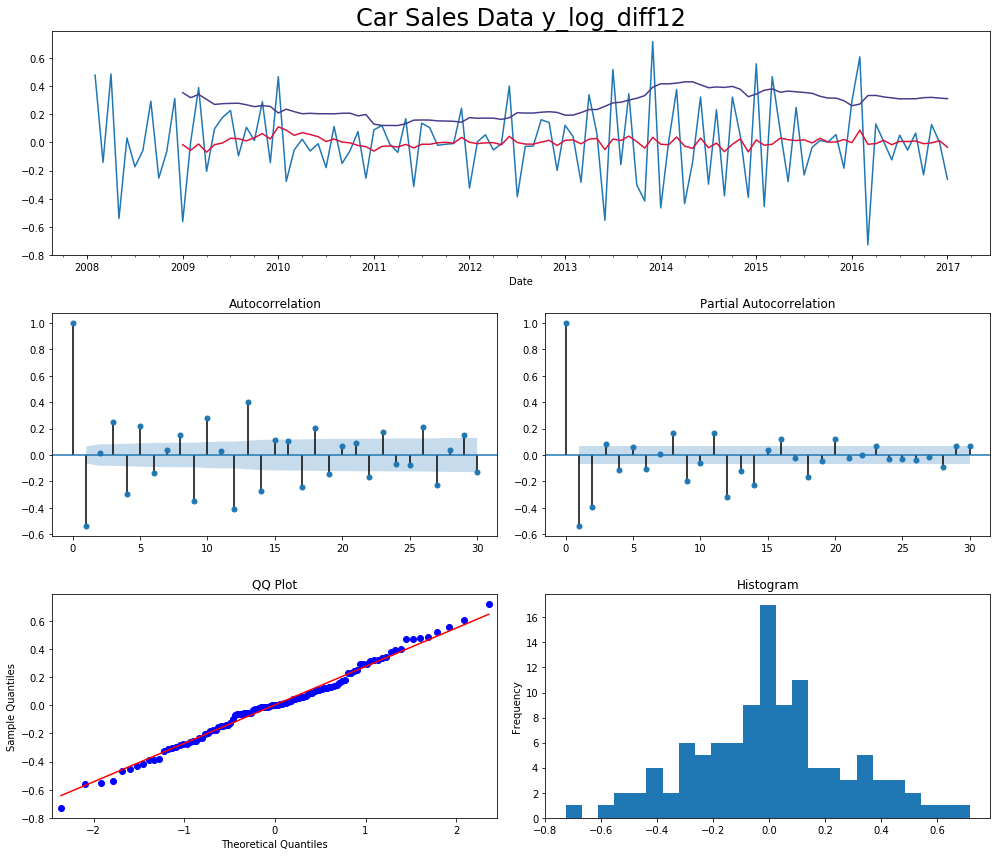

Results of Dickey-Fuller test:
test statistic          -4.868222
p-value                  0.000040
# of lags               13.000000
# of observations       94.000000
Critical Value (1%)     -3.501912
Critical Value (5%)     -2.892815
Critical Value (10%)    -2.583454
dtype: float64


In [2]:
# load required modules
from pandas import Series
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels as smt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

# create Series object
y = df['Quantity']
# difference time series
y_diff = np.diff(y)
#y_diff = pd.DataFrame(y_diff)
# log difference time series
y_log_diff = np.log(y).diff().dropna()
# log difference time series with seasonal difference
y_log_diff12 = np.log(y).diff().diff(12).dropna()

def ts_diagnostics(y, lags=None, title='', filename=''):
    '''
    Calculate acf, pacf, qq plot and Augmented Dickey Fuller test for a given time series
    '''
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    # monthly moving averages (12 day window because of months)
    rolling_mean = y.rolling(12).mean()
    rolling_std = y.rolling(12).std()
    
    fig = plt.figure(figsize=(14, 12))
    layout = (3, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    qq_ax = plt.subplot2grid(layout, (2, 0))
    hist_ax = plt.subplot2grid(layout, (2, 1))
    
    # time series plot
    y.plot(ax=ts_ax)
    rolling_mean.plot(ax=ts_ax, color='crimson');
    rolling_std.plot(ax=ts_ax, color='darkslateblue');
    plt.legend(loc='best')
    ts_ax.set_title(title, fontsize=24);
    
    # acf and pacf
    smt.graphics.tsaplots.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
    smt.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5) 
    
    # qq plot
    sm.qqplot(y, line='s', ax=qq_ax)
    qq_ax.set_title('QQ Plot')
    
    # hist plot
    y.plot(ax=hist_ax, kind='hist', bins=25);
    hist_ax.set_title('Histogram');
    plt.tight_layout();
    #plt.savefig('./img/{}.png'.format(filename))
    plt.show()
    
    # perform Augmented Dickey Fuller test
    print('Results of Dickey-Fuller test:')
    dftest = adfuller(y, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    return

# compute time series diagnostics
ts_diagnostics(y_diff, lags=30, title='Car Sales Data y_diff', filename='Car Sales Data')
ts_diagnostics(y_log_diff, lags=30, title='Car Sales Data y_log_diff', filename='Car Sales Data')
ts_diagnostics(y_log_diff12, lags=30, title='Car Sales Data y_log_diff12', filename='Car Sales Data')

# Here log transformation provides a good stationary series & will be used for further model development.


### Let's try and address outliers in the dataset. 
* Our approach is to remove the outlier points by eliminating any points that are above (Mean + 2*SD) and any points below (Mean - 2*SD)


* ARIMA model for time series forecasting. This section provides code to tune the parameters for ARIMA. 
* The best model is selected using AIC & forecasts are produced using the parameters associated with best model. 
* Instead of AIC we could also explore out of sample error for best model selection.

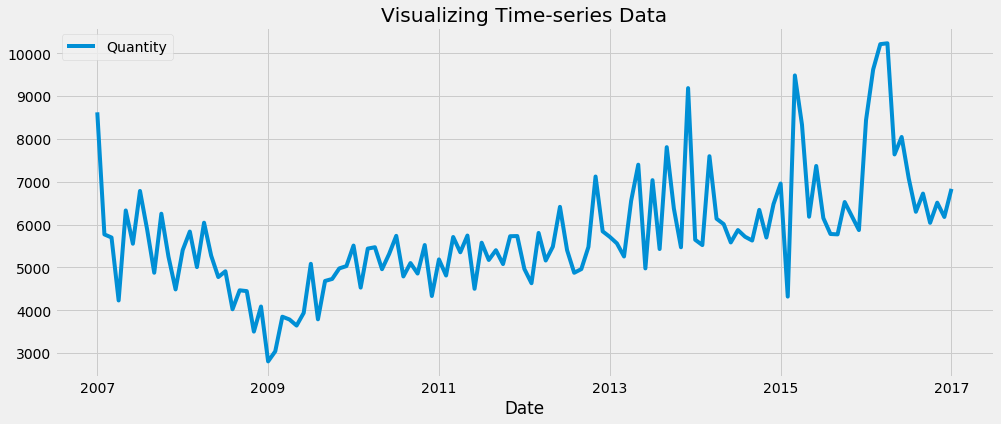

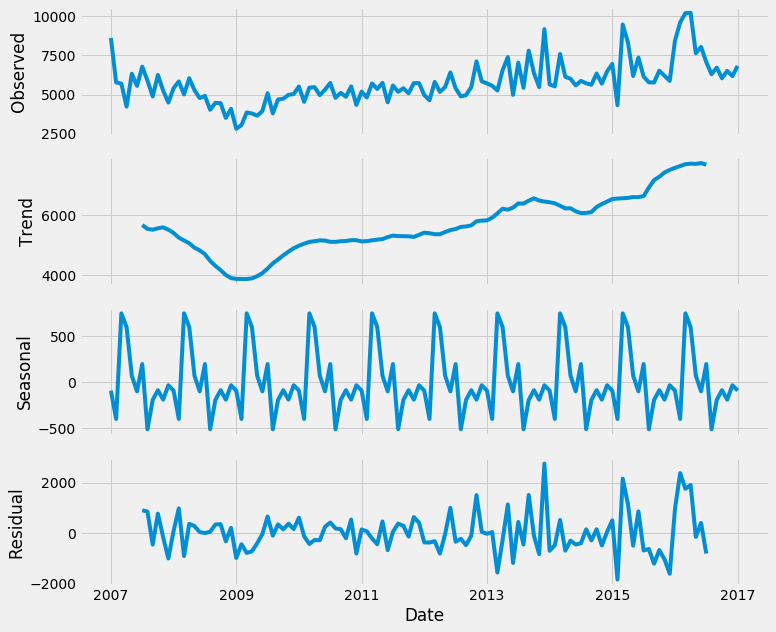

ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:1886.2715565785156
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:1669.0273815166643
ARIMA(0, 0, 0)x(1, 2, 0, 12) - AIC:1510.3916625529828
ARIMA(0, 0, 0)x(2, 0, 0, 12) - AIC:1664.7592444095771
ARIMA(0, 0, 0)x(2, 1, 0, 12) - AIC:1454.4047687964635
ARIMA(0, 0, 0)x(2, 2, 0, 12) - AIC:1266.0224678707164
ARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:1838.566438259788
ARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC:1672.8451500953747
ARIMA(0, 1, 0)x(1, 2, 0, 12) - AIC:1538.240519430175
ARIMA(0, 1, 0)x(2, 0, 0, 12) - AIC:1642.7525330694798
ARIMA(0, 1, 0)x(2, 1, 0, 12) - AIC:1461.742078847443
ARIMA(0, 1, 0)x(2, 2, 0, 12) - AIC:1297.956397695145
ARIMA(0, 2, 0)x(1, 0, 0, 12) - AIC:1938.9703860984803
ARIMA(0, 2, 0)x(1, 1, 0, 12) - AIC:1762.0342374993438
ARIMA(0, 2, 0)x(1, 2, 0, 12) - AIC:1612.7388433805982
ARIMA(0, 2, 0)x(2, 0, 0, 12) - AIC:1730.0541115640297
ARIMA(0, 2, 0)x(2, 1, 0, 12) - AIC:1538.209424740771
ARIMA(0, 2, 0)x(2, 2, 0, 12) - AIC:1361.6513352138422
ARIMA(1, 0, 0)x(0, 0, 0, 12) - AI

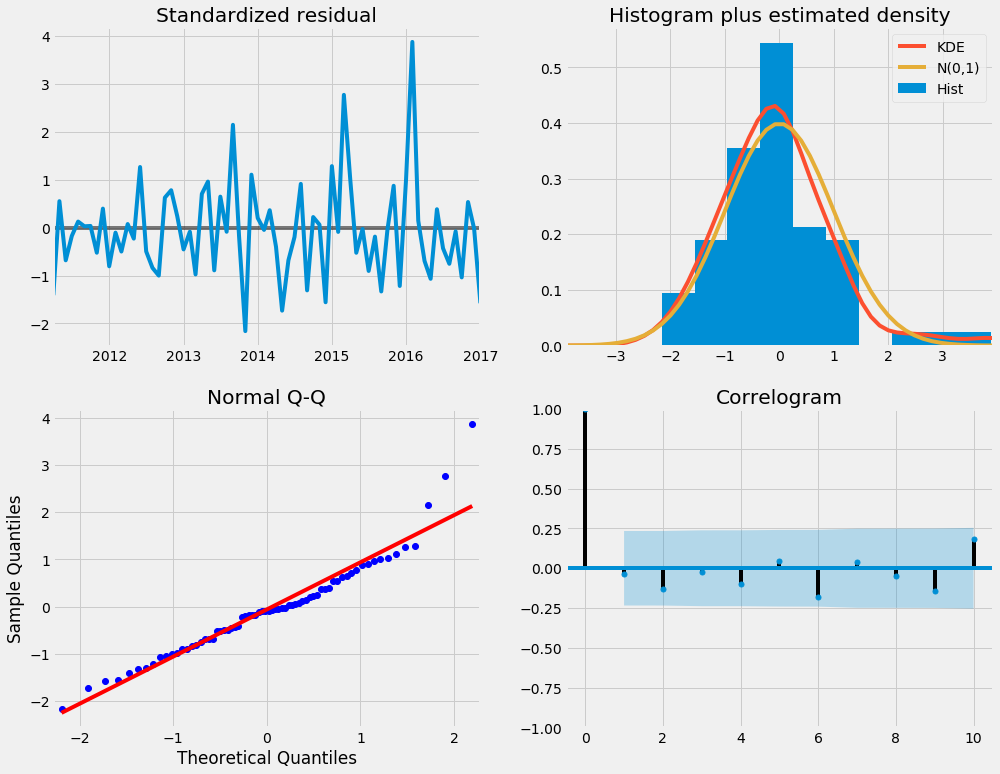

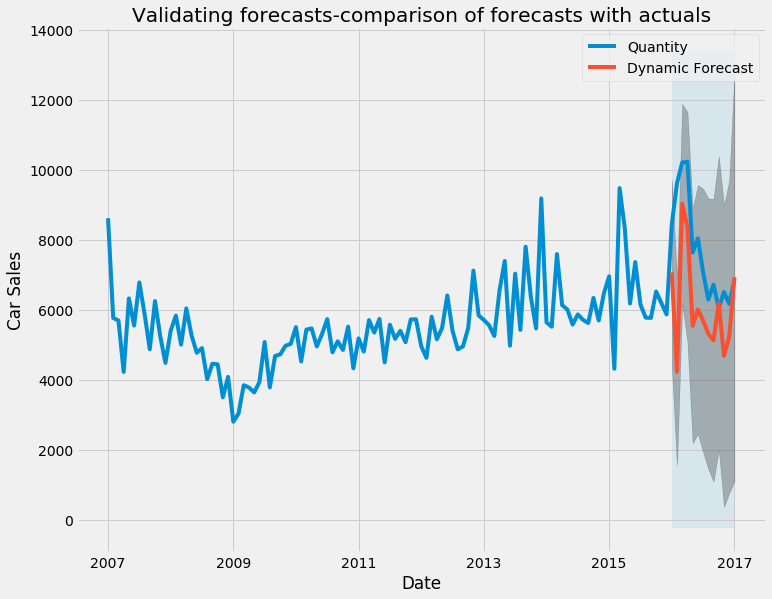

The Mean Squared Error of our forecasts is 2016-01-01 00:00:00   NaN
2016-02-01 00:00:00   NaN
2016-03-01 00:00:00   NaN
2016-04-01 00:00:00   NaN
2016-05-01 00:00:00   NaN
2016-06-01 00:00:00   NaN
2016-07-01 00:00:00   NaN
2016-08-01 00:00:00   NaN
2016-09-01 00:00:00   NaN
2016-10-01 00:00:00   NaN
2016-11-01 00:00:00   NaN
2016-12-01 00:00:00   NaN
2017-01-01 00:00:00   NaN
Quantity              NaN
dtype: float64


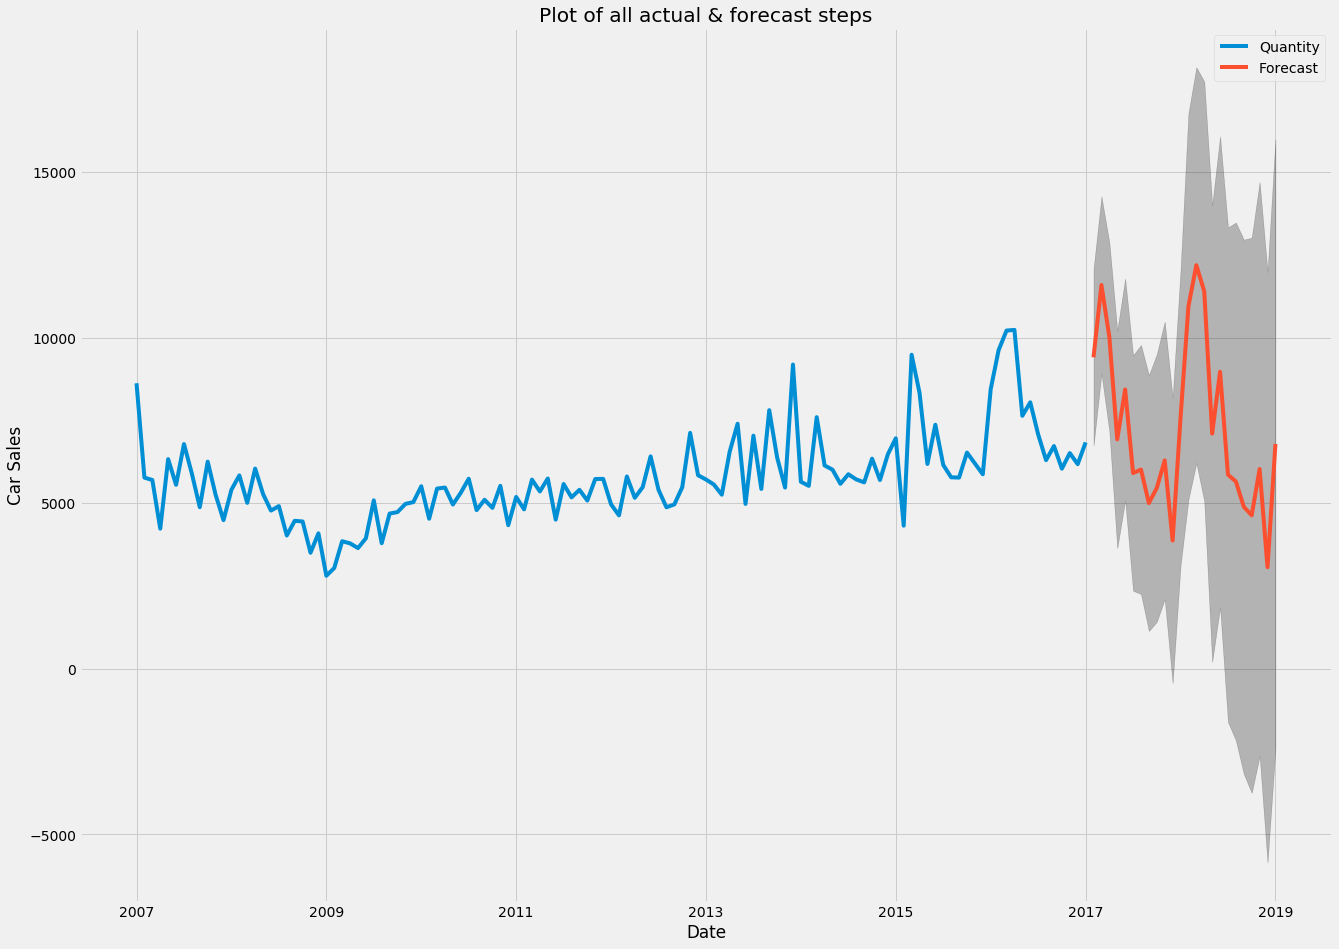

In [3]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

#Visualizing Time-series Data
df.plot(figsize=(15, 6))
plt.title('Visualizing Time-series Data')
plt.show()

#time-series seasonal decomposition
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
#plt.title('Visualizing time-series seasonal decomposition')
plt.show()

# Parameter Selection for the ARIMA Time Series Model

#Define the p, d and q parameters to take any value between 0 and 2
p = range(0, 3)
d = range(0, 3)
q = range(0, 1)

#Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

#Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

warnings.filterwarnings("ignore") # specify to ignore warning messages

# All combinations of parameters are used & best set of parameters with Minimum AIC is selected
AIC_list = pd.DataFrame({}, columns=['param','param_seasonal','AIC'])
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            temp = pd.DataFrame([[ param ,  param_seasonal , results.aic ]], columns=['param','param_seasonal','AIC'])
            AIC_list = AIC_list.append( temp, ignore_index=True)  # DataFrame append 는 일반 list append 와 다르게 이렇게 지정해주어야한다.
            del temp

        except:
            continue


m = np.nanmin(AIC_list['AIC'].values) # Find minimum value in AIC
l = AIC_list['AIC'].tolist().index(m) # Find index number for lowest AIC
Min_AIC_list = AIC_list.iloc[l,:]

# Fitting ARIMA model wtih best parameters obtained using Minimum AIC
mod = sm.tsa.statespace.SARIMAX(df,
                                order=Min_AIC_list['param'],
                                seasonal_order=Min_AIC_list['param_seasonal'],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

print("### Min_AIC_list ### \n{}".format(Min_AIC_list))

print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Validating Forecasts
pred_dynamic = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = df['2007':].plot(label='observed')
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-01-01'), df.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Car Sales')

plt.legend()
plt.title('Validating forecasts-comparison of forecasts with actuals')
plt.show()

#Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = df['2016-01-01':]

#Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))            
            
         
# Producing and Visualizing Forecasts
#Get forecast 'x' steps ahead in future
pred_uc = results.get_forecast(steps=24)

#Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

#plot the time series and forecasts of its future values
ax = df.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Car Sales')

plt.legend()
plt.title('Plot of all actual & forecast steps')
plt.show()